In [1]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import torchvision
from torchvision import transforms
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

Running on device: CUDA


In [2]:
def accuracy(net, loader, offset=0):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), ((targets+offset)%10).to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

In [3]:
def reset_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()
# https://discuss.pytorch.org/t/how-to-close-batchnorm-when-using-torchvision-models/21812/2
def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()
            
class HiddenDataset(Dataset):
    '''The hidden dataset.'''
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        return example[0], example[1], idx

# You can replace the below simple unlearning with your own unlearning function.

def training(
    net, 
    train_loader, 
    offset_range=0, 
    is_batchnorm_disabled=False):
    """Simple unlearning by finetuning."""
    epochs = 32
    criterion = nn.CrossEntropyLoss(reduction='none')
    net.apply(reset_batchnorm)
    net.train()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=4e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    coin = 0
    for ep in range(epochs):
        for i, (inputs, targets) in enumerate(train_loader):
            if targets.size(0)!=128:
                break
            coin = int(np.random.choice(range(offset_range)))
            targets = ((targets+coin)%10)
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            if is_batchnorm_disabled:
                net.apply(deactivate_batchnorm)
            optimizer.zero_grad()
            output0 = net(inputs)
            loss0 = criterion(output0, targets)

            loss = loss0.mean()
            loss.backward()
            optimizer.step()

        scheduler.step()
    net.eval()
    print(coin)
    return net

In [4]:
from load_cifar_script import get_cifar10_data

data_loaders = get_cifar10_data()

offset_range = 10
validation_accuracy = []

net = resnet18(pretrained=False, num_classes=10)
net.to(DEVICE)
net = training(net, data_loaders["training"], offset_range=offset_range, is_batchnorm_disabled=False)

for i in range(10):
    validation_accuracy.append(accuracy(net, data_loaders["validation"], i))

100%|██████████| 170498071/170498071 [00:16<00:00, 10184126.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


3


In [5]:
bn_validation_acc = np.array(validation_accuracy[-10:])
bn_validation_acc

array([0.0994, 0.0986, 0.1008, 0.095 , 0.1032, 0.1056, 0.0972, 0.0958,
       0.0998, 0.1046])

In [6]:
net = resnet18(pretrained=False, num_classes=10)
net.to(DEVICE)
net = training(net, data_loaders["training"], offset_range=offset_range, is_batchnorm_disabled=True)

for i in range(10):
    validation_accuracy.append(accuracy(net, data_loaders["validation"], i))

8


In [7]:
vanilla_validation_acc = np.array(validation_accuracy[-10:])
vanilla_validation_acc

array([0.0976, 0.1   , 0.1034, 0.0988, 0.099 , 0.1022, 0.0942, 0.1024,
       0.1072, 0.0952])

In [8]:
validation_acc_df = pd.DataFrame(list(zip(range(10), bn_validation_acc.tolist(), vanilla_validation_acc.tolist())), columns=["order", "bn", "vanilla"])
validation_acc_df.to_csv("ExC_validation_acc.csv",index=False)

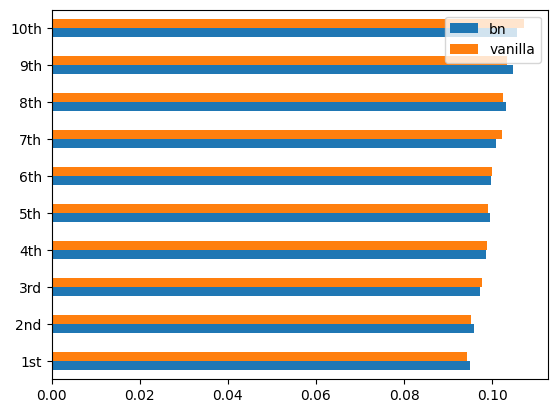

In [9]:
index = ["1st", "2nd", "3rd", "4th", "5th", "6th", "7th", "8th", "9th", "10th"]

df = pd.DataFrame({'bn': np.sort(bn_validation_acc).tolist(), 'vanilla': np.sort(vanilla_validation_acc,).tolist()}, index=index)
df.plot.barh()
plt.savefig('ExC_validation_acc.png')